In [1]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd

from tensorflow.keras.optimizers.schedules import InverseTimeDecay

import sys
sys.path.append('../..')
from utils.custom_models import AdaptativeDataWeightModel

2025-12-03 19:27:39.940416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Set the default float type to float64


In [2]:
df = pd.read_csv("../../data/FlunetData_United States of America_All Sites_for_28 October 2024 to 20 October 2025.csv")
df = df.sort_values("Week start date (ISO 8601 calendar)")
df = df[df["Surveillance site type"] == "Non-sentinel"]
df[:5]

,Unnamed: 0,Country area or territory,Surveillance site type,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A (H1N1)pdm09,A (H3),A (H5),A not subtyped,B (Victoria),B (lineage not determined)
0,1,United States of America,Non-sentinel,2024-44,2024-10-28,75257,917,74340,NaN,NaN,NaN,843,NaN,74
1,2,United States of America,Non-sentinel,2024-45,2024-11-04,76717,1172,75545,NaN,NaN,NaN,1088,NaN,84
2,3,United States of America,Non-sentinel,2024-46,2024-11-11,81959,1730,80229,NaN,NaN,NaN,1604,NaN,126
3,4,United States of America,Non-sentinel,2024-47,2024-11-18,86735,2458,84277,NaN,NaN,NaN,2291,NaN,167
4,5,United States of America,Non-sentinel,2024-48,2024-11-25,83810,3309,80501,NaN,NaN,NaN,3122,NaN,187


In [3]:
df["Year-week (ISO 8601 calendar)"]

0     2024-44
1     2024-45
2     2024-46
3     2024-47
4     2024-48
5     2024-49
6     2024-50
7     2024-51
8     2024-52
9     2025-01
10    2025-02
11    2025-03
12    2025-04
13    2025-05
14    2025-06
15    2025-07
16    2025-08
17    2025-09
18    2025-10
19    2025-11
20    2025-12
21    2025-13
22    2025-14
23    2025-15
24    2025-16
25    2025-17
26    2025-18
27    2025-19
28    2025-20
29    2025-21
30    2025-22
31    2025-23
32    2025-24
33    2025-25
34    2025-26
35    2025-27
36    2025-28
37    2025-29
Name: Year-week (ISO 8601 calendar), dtype: object

In [4]:

data_I = df["Influenza positive"].to_numpy()
# data_I = df["Specimen tested"].to_numpy()
data_I

array([  917,  1172,  1730,  2458,  3309,  5064,  9128, 17517, 23900,
       25274, 24600, 33734, 42608, 55042, 56036, 44722, 33909, 25963,
       18573, 14369, 10456,  8372,  6279,  4932,  3947,  3196,  2152,
        1459,  1151,   979,   883,   733,   511,   408,   298,   266,
         253,   142])

In [5]:
data_I.shape

(38,)

In [6]:
t_0, t_f = 0, len(data_I)
gamma = 0.1
N = 340000000 # population size

In [7]:
I_min, I_max = data_I.min(axis=0), data_I.max(axis=0)
I_mean, I_std = data_I.mean(axis=0), data_I.std(axis=0)

# Z Scaling
def scale(data):
    return (data - I_mean) / I_std

def unscale(data):
    return data * I_std + I_mean

# Min/Max
# def scale(data):
#     return (data - I_min) / (I_max - I_min)

# def unscale(data):
#     return I_min + (I_max - I_min) * data

In [8]:
data_I_scaled = scale(data_I)
I0 = data_I_scaled[0]
S0 = scale(N) - I0

In [9]:
S0, I0

(np.float64(21166.759354478538), np.float64(-0.7398490432062577))

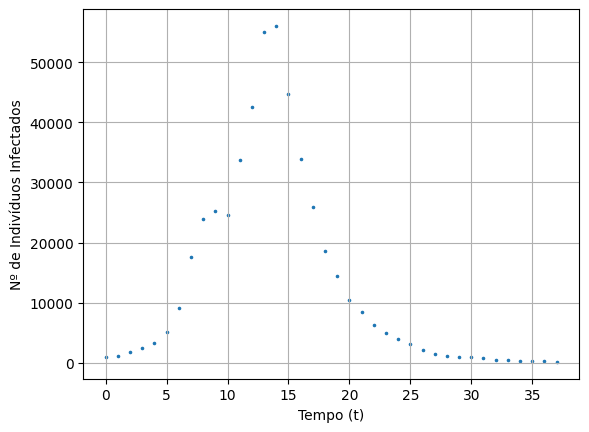

In [10]:
train_t = np.linspace(t_0, t_f - 1, t_f)
plt.scatter(train_t, data_I, s=2.5)
plt.xlabel("Tempo (t)")
plt.ylabel("Nº de Indivíduos Infectados")
plt.grid()
plt.savefig(f"../../images/data-eua-2025.png")
plt.show()

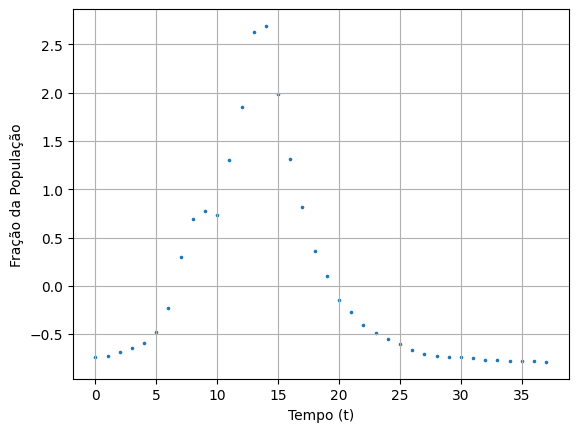

In [11]:
train_t = np.linspace(t_0, t_f - 1, t_f)
plt.scatter(train_t, data_I_scaled, s=2.5)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.show()

In [12]:
timeinterval = TimeDomain(t_0, t_f)

def sir_residual(t, y):

    # y *= tf.constant([[N] * 3 + [1] * 2] * y.shape[0], dtype='float64')

    # S, I, R, beta, gamma = y[:,0:1], y[:,1:2], y[:,2:3], y[:,3:4], y[:,4:5]
    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]

    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)
    # dR_dt = dde.gradients.jacobian(y, t, i=2)

    S_unscaled = unscale(S)
    N_unscaled = N / S_unscaled

    return [
        dS_dt - (-beta * S * I / N_unscaled),
        dI_dt - (beta * S * I / N_unscaled + gamma * I)
    ]


# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial

def S0_val(_): return S0
def I0_val(_): return I0
def R0_val(_): return R0

def beta0_val(_): return beta0
def gamma0_val(_): return gamma0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)
# ic_R = IC(timeinterval, R0_val, is_on_initial, component=2)

ic_beta = IC(timeinterval, beta0_val, is_on_initial, component=3)
ic_gamma = IC(timeinterval, gamma0_val, is_on_initial, component=4)

data_t = train_t.reshape(-1, 1)
data_I_bc = PointSetBC(data_t, data_I_scaled, component=1)

ics = [
    ic_S,
    ic_I
]

data_conds = [
    data_I_bc,
]

conditions = ics + data_conds

data = PDE(
    timeinterval,
    sir_residual,
    conditions,
    num_domain=len(data_I),
    num_boundary=2,
    num_test=len(data_I)//2,
    anchors=data_t
)

n_hidden_layers = 3
hidden_layer_size = 80  
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
# activation = ["tanh"] * n_hidden_layers + ["sigmoid"]

activation = "tanh"
initializer = "Glorot uniform"
# initializer = "Glorot normal"

# activation = "ReLU"
# initializer = "He uniform"
# initializer = "He normal"

optimizer = "adam"
lr = 0.002

eq_w = 1
ic_w = 1
data_w = 1

n_equations = 2

# Com L2
# loss_weights = [eq_w] * n_equations + [ic1_w, ic2_w, ic3_w]  + [data_w] * len(data_conds) + [1]

# Sem L2
loss_weights = [eq_w] * n_equations + [ic_w] * len(ics)  + [data_w] * len(data_conds)

# net = FNN(
#     topology,
#     activation,
#     initializer,
#     # regularization=["L2", 1e-5],
#     # dropout_rate=0.1,
# )

net = PFNN(
    topology,
    activation,
    initializer,
    # regularization=["L2", 1e-5],
    # dropout_rate=0,
)

model = AdaptativeDataWeightModel(data, net, n_physics=n_equations + len(ics), n_data=1)
# model = Model(data, net)

model.compile(
    optimizer,
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.013459 s



2025-12-03 19:27:46.936878: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1764800866.937681  157749 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1922 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [13]:
early_stopping = EarlyStopping(min_delta=1e-6, patience=2000)

adam_iterations = 100000

losshistory, train_state = model.train(
    iterations=adam_iterations, 
    display_every=100,
    callbacks=[
        early_stopping
    ]
)

# model.compile(
#     "L-BFGS", 
#     loss_weights=loss_weights
# )

# dde.optimizers.set_LBFGS_options(
#     # ftol=np.finfo(float).eps,
#     maxiter=25000,
#     ftol=1e-12,
#     gtol=1e-14
# )

# losshistory, train_state = model.train(
#     iterations=20000, 
#     display_every=100,
#     callbacks=[
#         early_stopping
#     ]
# )

Training model...



2025-12-03 19:27:49.779912: I external/local_xla/xla/service/service.cc:163] XLA service 0x563d3fa589b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-03 19:27:49.779935: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-12-03 19:27:49.801186: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 19:27:49.879312: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1764800870.243670  157749 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric
0         [1.15e-03, 8.35e-03, 4.48e+08, 5.47e-01, 1.72e+00]    [9.95e-04, 5.39e-03, 4.48e+08, 5.47e-01, 1.72e+00]    []  
100       [1.37e-02, 8.78e-05, 4.47e+08, 9.68e-02, 1.12e+00]    [1.42e-02, 7.93e-05, 4.47e+08, 9.68e-02, 1.12e+00]    []  
200       [1.79e-02, 2.40e-03, 4.46e+08, 1.85e-02, 1.06e+00]    [1.77e-02, 1.40e-03, 4.46e+08, 1.85e-02, 1.06e+00]    []  
300       [1.40e-02, 1.67e-03, 4.45e+08, 1.36e-02, 1.06e+00]    [1.38e-02, 9.22e-04, 4.45e+08, 1.36e-02, 1.06e+00]    []  
400       [1.34e-02, 1.71e-03, 4.45e+08, 1.25e-02, 1.05e+00]    [1.15e-02, 1.04e-03, 4.45e+08, 1.25e-02, 1.05e+00]    []  
500       [1.21e-02, 1.87e-03, 4.44e+08, 1.11e-02, 1.05e+00]    [9.00e-03, 1.34e-03, 4.44e+08, 1.11e-02, 1.05e+00]    []  
600       [1.15e-02, 2.51e-03, 4.43e+08, 1.10e-02, 1.05e+00]    [8.45e-03, 2.05e-03, 4.43e+08, 1.10e-02, 1.05e+00]    []  
700      

In [14]:
# model.save("../models/sir-nonoise")
# dde.saveplot(
#     losshistory, 
#     train_state, 
#     issave=True, 
#     isplot=False,
#     output_dir="../losses", 
#     loss_fname=f"loss-sir-nonoise",
#     train_fname=f"train-sir-nonoise",
#     test_fname=f"test-sir-nonoise")

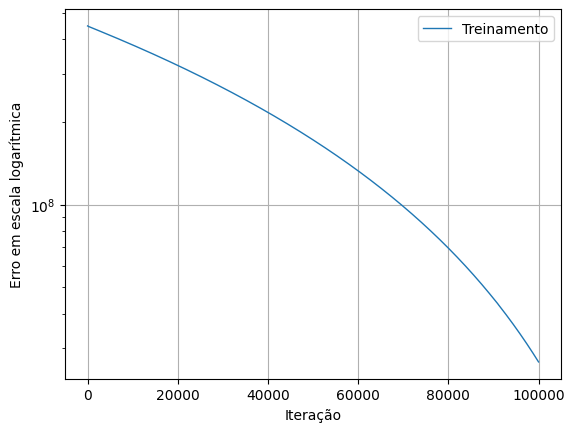

In [15]:
train = np.sum(losshistory.loss_train, axis=1)
plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
plt.savefig(f"../../images/loss-eua-2025.png")
plt.show()

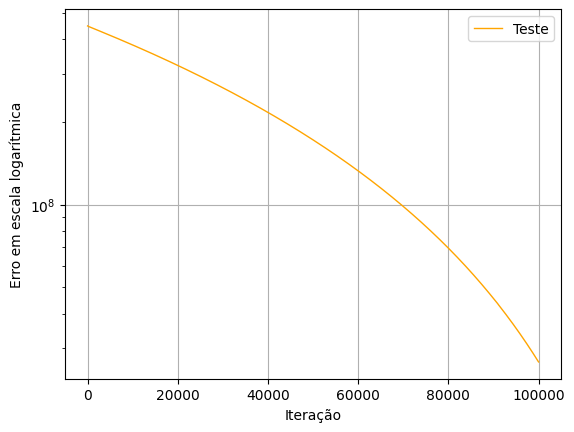

In [16]:
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, test, "-", label="Teste", color="orange", linewidth=1)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
# plt.savefig(f"../images/sir-loss-nonoise.png")
plt.show()

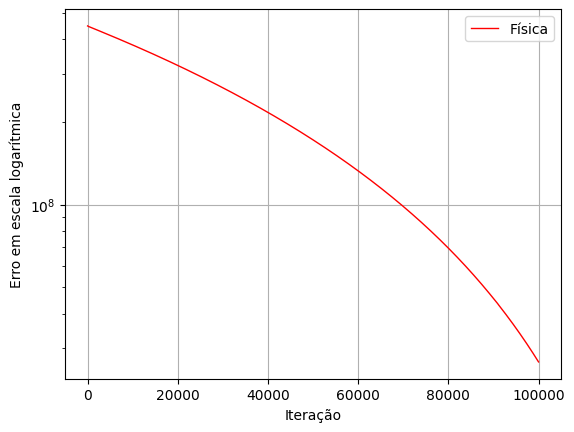

In [17]:
loss_train = np.array(losshistory.loss_train) 

train_phys = np.sum(loss_train[:,:len(ics) + n_equations], axis=1)
plt.semilogy(losshistory.steps, train_phys, "-", label="Física", color="red", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")
plt.legend()
plt.grid()
plt.show()

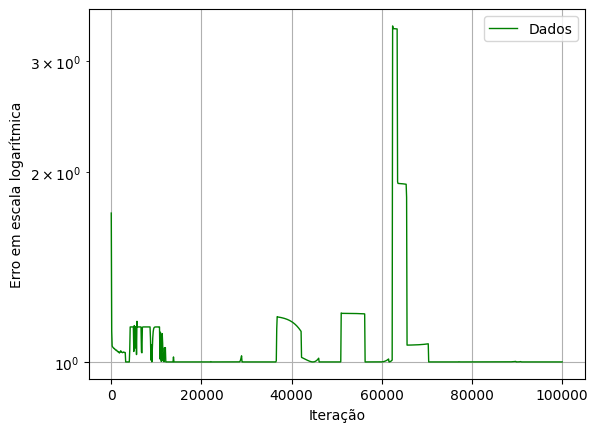

In [18]:
train_data = np.sum(loss_train[:,len(ics) + n_equations:], axis=1)
plt.semilogy(losshistory.steps, train_data, "-", label="Dados", color="green", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")
plt.legend()
plt.grid()
plt.show()

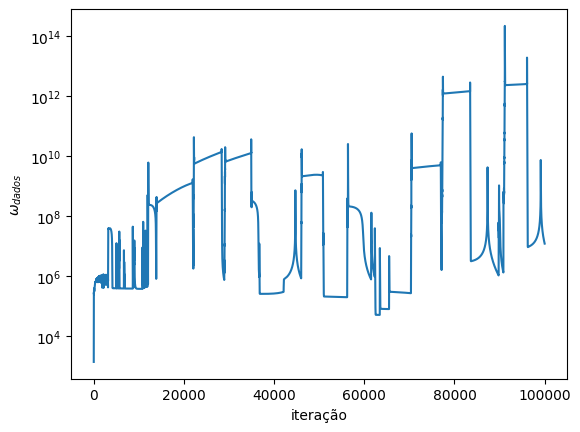

In [19]:
if isinstance(model, AdaptativeDataWeightModel):
    plt.semilogy(np.arange(len(model.data_weight_hist)), model.data_weight_hist)
    plt.xlabel("iteração")
    plt.ylabel("$\omega_{dados}$")
    plt.savefig("../../images/data-weight-usa-2025.png")
    plt.show()

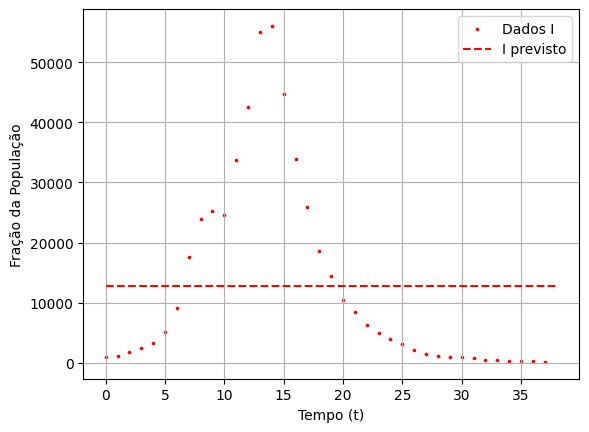

In [20]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t_0, t_f, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

I_pred = unscale(y_pred[:, 1])

plt.scatter(train_t, data_I, label="Dados I", color="red", s=2.5)
plt.plot(test_t, I_pred, label="I previsto", linestyle="--", color="red")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()
plt.savefig("../../images/predicted-invected-eua-2025.png")

plt.show()

[]

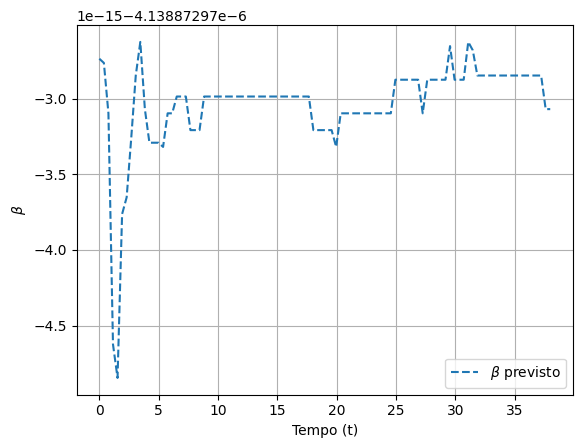

In [21]:
beta_pred = y_pred[:, 2]
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.savefig("../../images/predicted-beta-eua-2025.png")
plt.plot()

[]

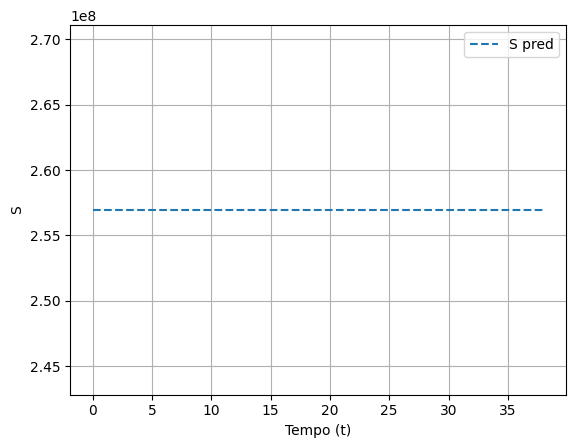

In [22]:
S_pred = unscale(y_pred[:, 0]) 
plt.plot(test_t, S_pred, label=r"S pred", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"S")
plt.legend()
plt.grid()
plt.plot()

[]

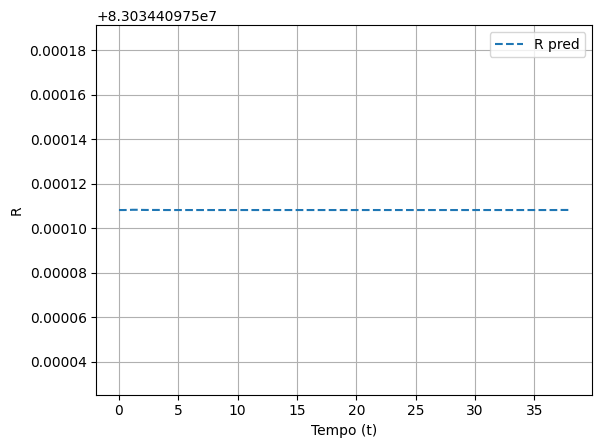

In [23]:
R_pred = N - S_pred - I_pred
plt.plot(test_t, R_pred, label=r"R pred", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"R")
plt.legend()
plt.grid()
plt.plot()